
**Main Model**
==

In [1]:
!git clone https://github.com/vlukiyanov/pt-sdae

Cloning into 'pt-sdae'...
remote: Enumerating objects: 323, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 323 (delta 0), reused 0 (delta 0), pack-reused 319
Receiving objects: 100% (323/323), 78.64 KiB | 454.00 KiB/s, done.
Resolving deltas: 100% (180/180), done.


In [1]:
%cd pt-sdae

/content/pt-sdae


In [3]:
!python setup.py install

/usr/local/lib/python3.9/dist-packages/setuptools/__init__.py:85: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated. Requirements should be satisfied by a PEP 517 installer. If you are using pip, you can try `pip install --use-pep517`.
  dist.fetch_build_eggs(dist.setup_requires)
running install
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating ptsdae.egg-info
writing ptsdae.egg-info/PKG-INFO
writing dependency_links to ptsdae.egg-info/dependency_links.txt
writing requirements to ptsdae.egg-info/requires.txt
writing top-level names to ptsdae.egg-info/top

In [4]:
!pip uninstall cytoolz

Found existing installation: cytoolz 0.12.1
Uninstalling cytoolz-0.12.1:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/cytoolz-0.12.1-py3.9-linux-x86_64.egg
Proceed (Y/n)? Y
  Successfully uninstalled cytoolz-0.12.1


In [5]:
!pip install cytoolz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.1 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
# Classifier
from sklearn.svm import SVC
# Character N-gram feature extractor
from sklearn.feature_extraction.text import CountVectorizer
# SDAE and model
from ptsdae.sdae import StackedDenoisingAutoEncoder
from ptsdae import model as ae
#from sdae import StackedDenoisingAE
# Util
from data_io import get_book
import torch

Create the training, test and validation sets

In [6]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
val_data = pd.read_csv("val.csv")

cv = CountVectorizer(analyzer='char', ngram_range=(1, 3), stop_words='english', dtype=np.float32)
X_train, X_test, X_val = cv.fit_transform(train_data.text.tolist()), cv.transform(test_data.text.tolist()), cv.transform(val_data.text.tolist())  
Y_train, Y_test, Y_val = train_data.author.tolist(), test_data.author.tolist(), val_data.author.tolist()


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


**Transform Y_train to one-hot encoded**

**Standardize datasets**

In [7]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, X_val = X_train.toarray(), X_test.toarray(), X_val.toarray()

scaler_train = StandardScaler()
scaler_train.fit(X_train)
X_train_scaled = torch.tensor(scaler_train.transform(X_train), dtype=torch.float32)

X_test_scaled = torch.tensor(scaler_train.transform(X_test), dtype=torch.float32)

X_val_scaled = torch.tensor(scaler_train.transform(X_val), dtype=torch.float32)

# Add Gaussian noise
#noise_factor = 0.1
#X_train_noisy = X_train_scaled + noise_factor * np.random.normal(loc=0.0, scale=1., size=X_train.shape)

print(X_train_scaled)

tensor([[ 1.4500,  1.4000,  1.2278,  ..., -0.1474, -0.1474, -0.1474],
        [-0.5260, -0.5123, -0.6869,  ..., -0.1474, -0.1474, -0.1474],
        [ 0.7717,  0.6023,  0.8595,  ..., -0.1474, -0.1474, -0.1474],
        ...,
        [ 0.3666,  0.4088,  0.3506,  ...,  6.7823,  6.7823,  6.7823],
        [ 0.1063,  0.0084,  0.2834,  ..., -0.1474, -0.1474, -0.1474],
        [ 0.1816,  0.0359,  0.1075,  ..., -0.1474, -0.1474, -0.1474]])


Simple linear SVM classifier

In [8]:
# SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, Y_train)

preds = svm.predict(X_test)

print(Y_test)
print("############################################")
print(preds)
error = np.mean(preds != Y_test)
print("Error of the computed SVM:", error)

['Burnett, Frances Hodgson', 'London, Jack', 'Spinoza, Benedictus de', 'Shakespeare, William', 'Warner, Charles Dudley', 'Paine, Albert Bigelow', 'Howells, William Dean', 'Arthur, T. S. (Timothy Shay)', 'Churchill, Winston', 'Ebers, Georg', 'Twain, Mark', 'Holmes, Oliver Wendell', 'Lytton, Edward Bulwer Lytton, Baron', 'Molière', 'Whittier, John Greenleaf', 'Cicero, Marcus Tullius', 'Glyn, Elinor', 'Quiller-Couch, Arthur', 'Rinehart, Mary Roberts', 'Jacobs, W. W. (William Wymark)', 'Bennett, Arnold', 'Molesworth, Mrs.', 'Shoghi, Effendi', 'Ballantyne, R. M. (Robert Michael)', 'Rohmer, Sax', 'Lang, Andrew', 'Smith, Francis Hopkinson', 'Lowndes, Marie Belloc', 'Duncan, Norman', 'Locke, William John', 'Holt, Emily Sarah', 'Pemberton, Max', 'Burroughs, John', 'Reynolds, Mack', 'Wallace, F. L. (Floyd L.)', 'Barr, Amelia E.', 'Raymond, Evelyn', 'Hall, E. Raymond (Eugene Raymond)', 'Bangs, John Kendrick', 'Dewey, John', 'Roy, Lillian Elizabeth', 'Drake, Samuel Adams', 'Leinster, Murray', 'Alg

In [9]:
from torch.utils.data import DataLoader, Dataset
import torch
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR

In [10]:
class SvmDataset(Dataset):
    def __init__(self, train):
        self.dataset = train
        self._cache = dict()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if index not in self._cache:
            self._cache[index] = ((torch.tensor(self.dataset[index])), 1)
            self._cache[index] = list(self._cache[index])
            self._cache[index][0] = self._cache[index][0].cuda(non_blocking=True)
            self._cache[index][1] = torch.tensor(self._cache[index][1]).cuda(
                non_blocking=True
            )
        return self._cache[index]

In [11]:

print(X_train.shape)
autoencoder = StackedDenoisingAutoEncoder(
        [X_train.shape[1], 500, 250, 50], final_activation=None
    )
X_train_data = SvmDataset(X_train_scaled)
X_val_data = SvmDataset(X_val_scaled)

print(X_train_data.__getitem__(0))
print(X_val_data.__getitem__(0))

print((X_train_data.__getitem__(0)[0]).shape)
print((X_val_data.__getitem__(0)[0]).shape)
  

(47, 8762)


<ipython-input-10-432c1cd8f16b>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._cache[index] = ((torch.tensor(self.dataset[index])), 1)


[tensor([ 1.4500,  1.4000,  1.2278,  ..., -0.1474, -0.1474, -0.1474],
       device='cuda:0'), tensor(1, device='cuda:0')]
[tensor([-0.8364, -0.8272, -0.8896,  ..., -0.1474, -0.1474, -0.1474],
       device='cuda:0'), tensor(1, device='cuda:0')]
torch.Size([8762])
torch.Size([8762])


In [12]:

autoencoder.cuda()
print("Pretraining stage.")
ae.pretrain(
    X_train_data,
    autoencoder,
    cuda=True,
    validation=X_val_data,
    epochs=100,
    batch_size=50,
    optimizer=lambda model: Adam(model.parameters()),
    scheduler=lambda x: StepLR(x, 100, gamma=0.1),
    corruption=0.2
)

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Pretraining stage.


  0%|          | 0/1 [00:00<?, ?batch/s, epo=0, lss=0.000000, vls=-1.000000]<ipython-input-10-432c1cd8f16b>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._cache[index] = ((torch.tensor(self.dataset[index])), 1)
100%|██████████| 1/1 [00:00<00:00, 218.36batch/s, epo=99, lss=0.128773, vls=16.643230]


In [13]:
print("Training stage.")
ae_optimizer = Adam(params=autoencoder.parameters())
ae.train(
    X_train_data,
    autoencoder,
    cuda=True,
    validation=X_val_data,
    epochs=70,
    batch_size=50,
    optimizer=ae_optimizer,
    corruption=0.2
)

Training stage.


100%|██████████| 1/1 [00:00<00:00, 153.66batch/s, epo=69, lss=0.090507, vls=28.071568]


In [14]:
print("SVM classifier stage")
dataloader = DataLoader(X_train_data, batch_size=10, shuffle=False)

svm = SVC(kernel='linear')
autoencoder.eval()
features = []
actual = []
print(len(dataloader))
for batch in dataloader:
    if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
        batch, value = batch  # if we have a prediction label, separate it to actual
        actual.append(value)

    batch = batch.cuda(non_blocking=True)
    features.append(autoencoder.encoder(batch).detach().cpu())

print(features)

SVM classifier stage
5
[tensor([[-3.3710e+00, -1.0488e+01, -4.9439e+00,  7.3420e+00, -9.4240e-02,
          1.1999e+00,  2.6440e+00,  1.5890e+00, -5.0671e+00, -5.8099e+00,
          5.4576e+00, -9.8918e+00, -4.7203e+00, -6.2612e+00,  6.5589e+00,
         -5.2556e+00,  3.7104e-01, -4.6000e+00, -3.0543e+00, -1.1973e+00,
         -9.7804e+00,  3.5161e+00,  2.9512e+00, -2.2396e+00,  2.8980e+00,
          5.1707e+00,  2.1721e+00, -2.1138e+00, -3.0351e+00,  1.2062e+00,
          4.7342e+00, -3.4866e+00, -2.5070e+00,  1.0398e+01, -1.5839e+00,
         -8.0507e-01, -5.5467e+00,  1.1340e+00, -2.6786e+00, -2.3463e+00,
          1.3694e+00,  1.5435e+00,  3.4487e+00,  6.8476e+00, -3.4124e+00,
         -5.0968e+00, -3.2850e+00, -3.8156e+00,  3.1699e+00, -5.6295e+00],
        [-2.9060e-01,  1.2367e+00, -3.8368e-01,  3.3794e+00, -3.2772e+00,
         -6.2234e-01,  1.5573e+00, -1.6349e+00,  3.5766e-01,  1.5367e+00,
         -8.6714e-01,  5.9580e-01, -1.9662e+00,  2.2905e+00,  4.3145e+00,
          3.5

In [15]:
svm.fit(torch.cat(features).numpy(), Y_train)

X_test_data = SvmDataset(X_test_scaled)
dataloader2 = DataLoader(X_test_data, batch_size=10, shuffle=False)

autoencoder.eval()
features2 = []
actual2 = []
for batch in dataloader2:
    if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
        batch, value = batch  # if we have a prediction label, separate it to actual
        actual2.append(value)
    batch = batch.cuda(non_blocking=True)
    features2.append(autoencoder.encoder(batch).detach().cpu())
  
predicted = svm.predict(torch.cat(features2))

print(predicted)
print("########################")
print(Y_test)
error = np.mean(predicted != Y_test)
print("Error of the computed SVM:", error)
#################################################################################

['Ballantyne, R. M. (Robert Michael)' 'Burnett, Frances Hodgson'
 'Spinoza, Benedictus de' 'Twain, Mark' 'Locke, William John'
 'Ballantyne, R. M. (Robert Michael)' 'Arthur, T. S. (Timothy Shay)'
 'Duncan, Norman' 'Ballantyne, R. M. (Robert Michael)' 'Ebers, Georg'
 'Lytton, Edward Bulwer Lytton, Baron' 'Dewey, John'
 'Ballantyne, R. M. (Robert Michael)' 'Molière' 'Dewey, John'
 'Churchill, Winston' 'Burnett, Frances Hodgson' 'Molesworth, Mrs.'
 'Ballantyne, R. M. (Robert Michael)' 'Burroughs, John'
 'Ballantyne, R. M. (Robert Michael)' 'Molesworth, Mrs.'
 'Shakespeare, William' 'Churchill, Winston' 'Shakespeare, William'
 'Ballantyne, R. M. (Robert Michael)' 'Jacobs, W. W. (William Wymark)'
 'Arthur, T. S. (Timothy Shay)' 'Dewey, John'
 'Ballantyne, R. M. (Robert Michael)' 'Ballantyne, R. M. (Robert Michael)'
 'Burnett, Frances Hodgson' 'London, Jack' 'Dewey, John' 'Dewey, John'
 'Ballantyne, R. M. (Robert Michael)' 'Molesworth, Mrs.' 'Twain, Mark'
 'Ballantyne, R. M. (Robert Michael)

<ipython-input-10-432c1cd8f16b>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._cache[index] = ((torch.tensor(self.dataset[index])), 1)



**Testing out the code from the example for ptsdae**
==



In [ ]:
!git clone https://github.com/vlukiyanov/pt-sdae

In [ ]:
%cd pt-sdae

In [ ]:
!python setup.py install

In [ ]:
!pip uninstall cytoolz

In [ ]:
!pip install cytoolz

In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 11.0 MB/s eta 0:00:00


In [ ]:
import click
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
from tensorboardX import SummaryWriter
from sklearn.cluster import KMeans
import uuid

import tensorflow as tf 

from ptsdae.sdae import StackedDenoisingAutoEncoder
import ptsdae.model as ae
from ptsdae.utils import cluster_accuracy


In [ ]:
class CachedMNIST(Dataset):
    def __init__(self, train, cuda, testing_mode=False):
        img_transform = transforms.Compose([transforms.Lambda(self._transformation)])
        self.ds = MNIST("./data", download=True, train=train, transform=img_transform)
        self.cuda = cuda
        self.testing_mode = testing_mode
        self._cache = dict()

    @staticmethod
    def _transformation(img):
        return (
            torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).float()
            * 0.02
        )

    def __getitem__(self, index: int) -> torch.Tensor:
        if index not in self._cache:
            self._cache[index] = list(self.ds[index])
            if self.cuda:
                self._cache[index][0] = self._cache[index][0].cuda(non_blocking=True)
                self._cache[index][1] = torch.tensor(self._cache[index][1]).cuda(
                    non_blocking=True
                )
        return self._cache[index]

    def __len__(self) -> int:
        return 128 if self.testing_mode else len(self.ds)


In [ ]:
def main(cuda=True, batch_size=128, pretrain_epochs=5, finetune_epochs=10, testing_mode=False):
    writer = SummaryWriter()  # create the TensorBoard object
    # callback function to call during training, uses writer from the scope

    def training_callback(epoch, lr, loss, validation_loss):
        writer.add_scalars(
            "data/autoencoder",
            {"lr": lr, "loss": loss, "validation_loss": validation_loss,},
            epoch,
        )

    ds_train = CachedMNIST(
        train=True, cuda=cuda, testing_mode=testing_mode
    )  # training dataset
    ds_val = CachedMNIST(
        train=False, cuda=cuda, testing_mode=testing_mode
    )  # evaluation dataset
    autoencoder = StackedDenoisingAutoEncoder(
        [28 * 28, 500, 500, 2000, 10], final_activation=None
    )
    if cuda:
        autoencoder.cuda()
    print("Pretraining stage.")
    ae.pretrain(
        ds_train,
        autoencoder,
        cuda=cuda,
        validation=ds_val,
        epochs=pretrain_epochs,
        batch_size=batch_size,
        optimizer=lambda model: SGD(model.parameters(), lr=0.1, momentum=0.9),
        scheduler=lambda x: StepLR(x, 100, gamma=0.1),
        corruption=0.2,
    )
    print("Training stage.")
    ae_optimizer = SGD(params=autoencoder.parameters(), lr=0.1, momentum=0.9)
    ae.train(
        ds_train,
        autoencoder,
        cuda=cuda,
        validation=ds_val,
        epochs=finetune_epochs,
        batch_size=batch_size,
        optimizer=ae_optimizer,
        scheduler=StepLR(ae_optimizer, 100, gamma=0.1),
        corruption=0.2,
        update_callback=training_callback,
    )
    print("k-Means stage")
    dataloader = DataLoader(ds_train, batch_size=50, shuffle=False)
    kmeans = KMeans(n_clusters=10, n_init=20)
    autoencoder.eval()
    features = []
    actual = []
    for batch in dataloader:
        if (isinstance(batch, tuple) or isinstance(batch, list)) and len(batch) == 2:
            batch, value = batch  # if we have a prediction label, separate it to actual
            actual.append(value)
        if cuda:
            batch = batch.cuda(non_blocking=True)
        features.append(autoencoder.encoder(batch).detach().cpu())
    actual = torch.cat(actual).long().cpu().numpy()
    predicted = kmeans.fit_predict(torch.cat(features).numpy())
    reassignment, accuracy = cluster_accuracy(actual, predicted)
    print("Final k-Means accuracy: %s" % accuracy)
    predicted_reassigned = [reassignment[item] for item in predicted]  # TODO numpify
    if not testing_mode:
        confusion = confusion_matrix(actual, predicted_reassigned)
        normalised_confusion = (
            confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
        )
        confusion_id = uuid.uuid4().hex
        sns.heatmap(normalised_confusion).get_figure().savefig(
            "confusion_%s.png" % confusion_id
        )
        print("Writing out confusion diagram with UUID: %s" % confusion_id)
        writer.add_embedding(
            torch.cat(features),
            metadata=predicted,
            label_img=ds_train.ds.train_data.float().unsqueeze(1),  # TODO bit ugly
            tag="predicted",
        )
        writer.close()

100%|██████████| 9912422/9912422 [00:00<00:00, 320175207.69it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24986735.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 159070115.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8232726.35it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Pretraining stage.


  0%|          | 0/469 [00:00<?, ?batch/s, epo=0, lss=0.000000, vls=-1.000000]<ipython-input-20-b1a5b93bd95a>:12: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).float()
100%|██████████| 469/469 [00:01<00:00, 310.25batch/s, epo=4, lss=0.005582, vls=0.005693]


Training stage.


100%|██████████| 469/469 [00:01<00:00, 239.89batch/s, epo=9, lss=0.478914, vls=0.480499]


k-Means stage
Final k-Means accuracy: 0.7319333333333333
Writing out confusion diagram with UUID: b031071b4fbf4a2087383d08af0be23b


/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


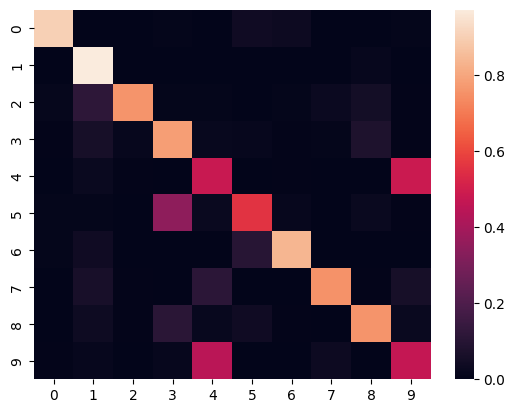

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
def main(cuda=True, batch_size=128, pretrain_epochs=30, finetune_epochs=10, testing_mode=False):
    writer = SummaryWriter()  # create the TensorBoard object
    # callback function to call during training, uses writer from the scope

    def training_callback(epoch, lr, loss, validation_loss):
        writer.add_scalars(
            "data/autoencoder",
            {"lr": lr, "loss": loss, "validation_loss": validation_loss,},
            epoch,
        )

    ds_train = CachedMNIST(
        train=True, cuda=cuda, testing_mode=testing_mode
    )  # training dataset
    ds_val = CachedMNIST(
        train=False, cuda=cuda, testing_mode=testing_mode
    )  # evaluation dataset
    autoencoder = StackedDenoisingAutoEncoder(
        [28 * 28, 500, 500, 2000, 10], final_activation=None
    )
    print(ds_train.__getitem__(2))
    print((ds_train.__getitem__(2)[0]).shape)

    dataloader = DataLoader(ds_train, batch_size=1024, shuffle=False)

    print(len(dataloader))
  

In [ ]:
if __name__ == "__main__":
    main()

[tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000,

<ipython-input-75-b86a47cfb085>:15: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).float()


**Using DAE from keras library**
==

In [ ]:
import numpy as np
import os
import pandas as pd
# Classifier
from sklearn.svm import SVC
# Character N-gram feature extractor
from sklearn.feature_extraction.text import CountVectorizer
# SDAE and model
from keras.layers import Input, Dense
from keras.models import Model
# Util
from data_io import get_book
import torch


In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
val_data = pd.read_csv("val.csv")

cv = CountVectorizer(analyzer='char', ngram_range=(2, 4), stop_words='english')
X_train, X_test, X_val = cv.fit_transform(train_data.text.tolist()), cv.transform(test_data.text.tolist()), cv.transform(val_data.text.tolist())  
Y_train, Y_test, Y_val = train_data.author.tolist(), test_data.author.tolist(), val_data.author.tolist()

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [ ]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, X_val = X_train.toarray(), X_test.toarray(), X_val.toarray()

scaler_train = StandardScaler()
scaler_train.fit(X_train)
X_train_scaled = scaler_train.transform(X_train)

scaler_test = StandardScaler()
scaler_test.fit(X_test)
X_test_scaled = scaler_test.transform(X_test)

scaler_val = StandardScaler()
scaler_val.fit(X_val)
X_val_scaled = scaler_val.transform(X_val)

# Add Gaussian noise
noise_factor = 0.1
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1., size=X_train.shape)
scaler_noisy = StandardScaler()
scaler_noisy.fit(X_train_noisy)
X_train_noisy_scaled1 = scaler_noisy.transform(X_train_noisy)

X_train_noisy_scaled = X_train_scaled + noise_factor * np.random.normal(loc=0.0, scale=1., size=X_train.shape)

scaler_noisy2 = StandardScaler()
scaler_noisy2.fit(X_train_noisy_scaled)
X_train_noisy_scaled2 = scaler_noisy2.transform(X_train_noisy_scaled)

print(X_train_scaled)
print(X_train_noisy_scaled1)

[[ 1.399956    1.22775537  0.         ... -0.14744196 -0.14744196
  -0.14744196]
 [-0.51226334 -0.68690124 -0.59347976 ... -0.14744196 -0.14744196
  -0.14744196]
 [ 0.60230521  0.85951239  0.11869595 ... -0.14744196 -0.14744196
  -0.14744196]
 ...
 [ 0.40880683  0.35059232  3.67957451 ...  6.78232998  6.78232998
   6.78232998]
 [ 0.00841917  0.28335694 -0.2373919  ... -0.14744196 -0.14744196
  -0.14744196]
 [ 0.0358705   0.10751058 -0.11869595 ... -0.14744196 -0.14744196
  -0.14744196]]
[[ 1.39997994e+00  1.22782632e+00  7.72688486e-04 ...  1.41946904e-02
  -7.95291223e-01  8.24077889e-02]
 [-5.12296164e-01 -6.86927109e-01 -5.91806809e-01 ... -7.93763507e-03
   8.86765082e-01 -2.89515330e-01]
 [ 6.02322805e-01  8.59479451e-01  1.21523012e-01 ...  8.79759881e-02
  -7.84882166e-01 -3.75581629e-01]
 ...
 [ 4.08820793e-01  3.50567157e-01  3.68903142e+00 ...  6.60545974e+00
   5.56212227e+00  6.10458043e+00]
 [ 8.41577482e-03  2.83440554e-01 -2.50421730e-01 ... -3.26589072e-02
  -6.61004317

In [ ]:
input_shape = (X_train_scaled.shape[1],)
encoder_input = Input(shape=input_shape)

In [ ]:
encoder = Dense(50, activation='relu')(encoder_input)
decoder = Dense(X_train.shape[1], activation='sigmoid')(encoder)

In [ ]:
# Other implementations of DAE
encoder = Dense(49, activation='relu')(encoder_input)
encoder = Dense(20, activation='relu')(encoder)
encoder = Dense(10, activation='relu')(encoder)

decoder = Dense(20, activation='relu')(encoder)
decoder = Dense(40, activation='relu')(decoder)
decoder = Dense(X_train.shape[1], activation='sigmoid')(decoder)

In [ ]:
autoencoder = Model(encoder_input, decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(X_train_noisy_scaled2, X_train_scaled, epochs=20, batch_size=10, validation_data=(X_val_scaled, X_val_scaled))

Epoch 1/20
5/5 [==============================] - 0s 56ms/step - loss: -15394.3008 - val_loss: -16839.5703
Epoch 2/20
5/5 [==============================] - 0s 30ms/step - loss: -21451.6348 - val_loss: -23393.5137
Epoch 3/20
5/5 [==============================] - 0s 39ms/step - loss: -30023.0742 - val_loss: -32009.7656
Epoch 4/20
5/5 [==============================] - 0s 32ms/step - loss: -39455.2656 - val_loss: -43435.5742
Epoch 5/20
5/5 [==============================] - 0s 32ms/step - loss: -54012.2656 - val_loss: -58206.6523
Epoch 6/20
5/5 [==============================] - 0s 30ms/step - loss: -72488.5469 - val_loss: -77263.6719
Epoch 7/20
5/5 [==============================] - 0s 33ms/step - loss: -97431.8203 - val_loss: -101579.2109
Epoch 8/20
5/5 [==============================] - 0s 30ms/step - loss: -124017.5078 - val_loss: -131284.4375
Epoch 9/20
5/5 [==============================] - 0s 31ms/step - loss: -162006.8125 - val_loss: -168422.3438
Epoch 10/20
5/5 [===============

In [ ]:
encoder = Model(encoder_input, encoder)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)
X_val_encoded = encoder.predict(X_val_scaled)

ValueError: ignored

In [ ]:
# Train an SVM classifier on the encoded feature vectors
svm = SVC(kernel='linear')
svm.fit(X_train_encoded, Y_train)

# Evaluate the trained SVM on the test and validation sets
print("Accuracy on train set:", svm.score(X_train_encoded, Y_train))
print("Accuracy on test set:", svm.score(X_test_encoded, Y_test))
print("Accuracy on validation set:", svm.score(X_val_encoded, Y_val))

Accuracy on train set: 1.0
Accuracy on test set: 0.0
Accuracy on validation set: 0.02127659574468085


**Other implementations of DAE**

In [ ]:
class SDAEModel:
  def __init__():
    pass
  
  def forward(input_):
    encoder_input = Input(shape = (input_.shape[1], ))
    encoder = Dense(500, activation='relu')(encoder_input)
    encoder = Dense(250, activation='relu')(encoder)
    encoder = Dense(100, activation='relu')(encoder)

    decoder = Dense(250, activation='relu')(encoder)
    decoder = Dense(500, activation='relu')(decoder)
    decoder = Dense(X_train.shape[1], activation='sigmoid')(decoder)

    return 


**Using SDAE from SDAE library**
==



In [ ]:
!git clone https://github.com/MadhumitaSushil/SDAE

In [ ]:
%cd SDAE

In [ ]:
import os
import numpy as np
import pandas as pd
# Classifier
from sklearn.svm import SVC
# Character N-gram feature extractor
from sklearn.feature_extraction.text import CountVectorizer
# SDAE and model
from ptsdae.sdae import StackedDenoisingAutoEncoder
from ptsdae import model as ae
#from sdae import StackedDenoisingAE
# Util
from data_io import get_book
import torch

In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
val_data = pd.read_csv("val.csv")

cv = CountVectorizer(analyzer='char', ngram_range=(1, 3), stop_words='english', dtype=np.float32)
X_train, X_test, X_val = cv.fit_transform(train_data.text.tolist()), cv.transform(test_data.text.tolist()), cv.transform(val_data.text.tolist())  
Y_train, Y_test, Y_val = train_data.author.tolist(), test_data.author.tolist(), val_data.author.tolist()

In [ ]:
sdae = StackedDenoisingAE(n_layers = 3, 
                          n_hid = [X_train.shape[1], 
                          256, 128], dropout = [0.1],
                          enc_act = ['relu'], dec_act = ['relu', 'relu', 'sigmoid'],
                          nb_epoch = 30, optimizer = 'adam', batch_size = 27)

In [ ]:
model, (dense_train, dense_val, dense_test), recon_mse = sdae.get_pretrained_sda(X_train,
                                                                                 X_val,
                                                                                 X_test,
                                                                                 dir_out = '../output/')